In [1]:
from dappy import read
from dappy import vis
import numpy as np
import time
# from IPython.display import Video
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

from dappy import preprocess
from dappy import write
from dappy import features
from dappy import analysis
import pandas as pd
import copy
import os
%matplotlib inline

In [ ]:
# import jdc # used fo defining functions for a class in separate cells
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.interpolate import make_interp_spline
from tqdm import tqdm # for showing progress bar in for loops
from scipy.stats import pearsonr

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [3]:
def reset_rcparams():
    matplotlib.rcdefaults()
    matplotlib.rcParams['font.family'] = "Arial"
    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['lines.linewidth'] = 0.8
    plt.rcParams['axes.labelpad'] = 2

    major = 2
    majorpad = 2
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['ytick.major.size'] = major
    plt.rcParams['xtick.major.width'] = 0.4
    plt.rcParams['ytick.major.width'] = 0.4
    plt.rcParams['xtick.major.pad'] = majorpad
    plt.rcParams['ytick.major.pad'] = majorpad
    plt.rcParams['xtick.labelsize'] = 5
    plt.rcParams['ytick.labelsize'] = 5
    plt.rcParams['axes.labelsize'] = 5

    plt.rcParams["legend.borderpad"] = 0
    plt.rcParams["legend.framealpha"] = 0
    plt.rcParams["legend.fontsize"] = 5

def hide_axes_top_right(ax):
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

def hide_axes_all(ax):
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)

# every dimension is in millimeter
mm = 1/25.4

In [4]:
# analysis_key = "SU_trial"
analysis_key = "cross_test_align"
config = read.config("/hpc/group/tdunn/Bryan_Rigs/SmallOpenField/dappy/configs/" + analysis_key + ".yaml")
do_diff_ds = False
drop_tail = True
drop_shoulders = False #True
tail_kps = [6,7]

connectivity = read.connectivity(
    path=config["skeleton_path"], skeleton_name=config["skeleton_name"]
)

# Make out_path
Path(config["out_path"]).mkdir(parents=True, exist_ok=True)

# Merge prediction
pose, ids, meta, meta_by_frame = read.pose_from_meta(
    path=config["meta_path"], connectivity=connectivity
)

if drop_tail:
    tail_kps = [6,7]
    pose = np.delete(pose, tail_kps, axis=1)
    connectivity.links[connectivity.links > 7] -= len(tail_kps)
    connectivity.angles[connectivity.angles > 7] -= len(tail_kps)
    connectivity.joint_names.remove(connectivity.joint_names[7])
    connectivity.joint_names.remove(connectivity.joint_names[6])

    print("Shape of pose =", pose.shape)
    print("links = ", connectivity.links)
    print('Angles = ', connectivity.angles)

if drop_shoulders:
    shoulder_kps = [11-2,15-2]
    pose = np.delete(pose, shoulder_kps, axis=1)
    connectivity.links[connectivity.links > 15-2] -= 1
    connectivity.links[connectivity.links > 11-2] -= 1
    connectivity.angles[connectivity.angles > 15-2] -= 1
    connectivity.angles[connectivity.angles > 11-2] -= 1
    connectivity.joint_names.remove(connectivity.joint_names[15-2])
    connectivity.joint_names.remove(connectivity.joint_names[11-2])


if do_diff_ds:
    pose_90fps_rig = pose[np.isin(ids, [range(7)])][::3]
    ids_90fps_rig = ids[np.isin(ids, [range(7)])][::3]
    mbf_90fps_rig = meta_by_frame[np.isin(ids, [range(7)])][::3]

    pose_30fps_rig = pose[np.isin(ids, [range(7,12)])]
    ids_30fps_rig = ids[np.isin(ids, [range(7,12)])]
    mbf_30fps_rig = meta_by_frame[np.isin(ids, [range(7,12)])]

    pose = np.append(pose_90fps_rig, pose_30fps_rig, axis=0)
    ids = np.append(ids_90fps_rig, ids_30fps_rig, axis=0)
    meta_by_frame = pd.concat([mbf_90fps_rig, mbf_30fps_rig])


write.pose_h5(pose,ids, config['data_path'] + 'pose_merged.h5')
# Read pose_merged.h if already saved
# pose, ids = read.pose_h5(config["data_path"] + "pose_merged.h5")

print("Pose shape (# frames x # keypoints x 3 coordinates): ")
print(pose.shape)

print(meta)
print("\n" + str(ids))

pose_aligned = preprocess.align_floor_by_id(pose=pose, ids=ids, foot_id=12, head_id=0)
# write.pose_h5(pose_aligned, ids, config["data_path"] + "pose_aligned.h5")

12it [00:03,  3.72it/s]


Shape of pose = (2904000, 20, 3)
links =  [[ 0  1]
 [ 1  2]
 [ 0  2]
 [ 0  3]
 [ 1  3]
 [ 2  3]
 [ 3  4]
 [ 4  5]
 [ 3  5]
 [ 6  7]
 [ 7  8]
 [ 8  9]
 [ 9  3]
 [ 8  3]
 [10 11]
 [11 12]
 [12 13]
 [13  3]
 [12  3]
 [14 15]
 [15 16]
 [16  4]
 [17 18]
 [18 19]
 [19  4]]
Angles =  [[ 2  1  3]
 [ 2  0  3]
 [ 1  3  4]
 [ 0  3  4]
 [ 2  3  4]
 [ 3  4  5]
 [ 1  3 13]
 [ 0  3 13]
 [ 2  3 13]
 [ 4  3 13]
 [ 1  3  9]
 [ 0  3  9]
 [ 2  3  9]
 [ 4  3  9]
 [10 11 12]
 [11 12 13]
 [12 13  3]
 [ 6  7  8]
 [ 7  8  9]
 [ 8  9  3]
 [16  4  3]
 [16  4  5]
 [19  4  3]
 [19  4  5]
 [14 15 16]
 [15 16  4]
 [17 18 19]
 [18 19  4]
 [ 2  3  6]
 [ 2  3  7]
 [ 2  3  8]
 [ 2  3 10]
 [ 2  3 11]
 [ 2  3 12]
 [ 5  4 14]
 [ 5  4 15]
 [ 5  4 17]
 [ 5  4 18]
 [ 4  5 14]
 [ 4  5 15]
 [ 4  5 17]
 [ 4  5 18]
 [ 2  3  5]
 [ 2  4 14]
 [ 2  4 15]
 [ 2  4 16]
 [ 2  4 17]
 [ 2  4 18]
 [ 2  4 19]
 [ 2  0 14]
 [ 2  0 15]
 [ 2  0 16]
 [ 2  1 17]
 [ 2  1 18]
 [ 2  1 19]]
Pose shape (# frames x # keypoints x 3 coordinates): 
(290400

  0%|                                                                                                                            | 0/12 [00:00<?, ?it/s]

Fitting and rotating the floor for each video to alignment ... 


  8%|█████████▋                                                                                                          | 1/12 [00:00<00:03,  3.37it/s]

Fitting and rotating the floor for each video to alignment ... 


 17%|███████████████████▎                                                                                                | 2/12 [00:00<00:04,  2.13it/s]

Fitting and rotating the floor for each video to alignment ... 


 25%|█████████████████████████████                                                                                       | 3/12 [00:01<00:03,  2.57it/s]

Fitting and rotating the floor for each video to alignment ... 


 33%|██████████████████████████████████████▋                                                                             | 4/12 [00:01<00:03,  2.12it/s]

Fitting and rotating the floor for each video to alignment ... 


 42%|████████████████████████████████████████████████▎                                                                   | 5/12 [00:02<00:03,  1.94it/s]

Fitting and rotating the floor for each video to alignment ... 


 50%|██████████████████████████████████████████████████████████                                                          | 6/12 [00:02<00:02,  2.27it/s]

Fitting and rotating the floor for each video to alignment ... 


 58%|███████████████████████████████████████████████████████████████████▋                                                | 7/12 [00:02<00:01,  2.55it/s]

Fitting and rotating the floor for each video to alignment ... 
Fitting and rotating the floor for each video to alignment ... 
Fitting and rotating the floor for each video to alignment ... 


 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 10/12 [00:03<00:00,  3.46it/s]

Fitting and rotating the floor for each video to alignment ... 


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 11/12 [00:04<00:00,  2.85it/s]

Fitting and rotating the floor for each video to alignment ... 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.52it/s]


# CCM Algorithm 

**Adopted from https://phdinds-aim.github.io/time_series_handbook/06_ConvergentCrossMappingandSugiharaCausality/ccm_sugihara.html**

In [30]:
# Computing "Causality" (Correlation between True and Predictions)
class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):
        '''
        X: timeseries for variable X that could cause Y
        Y: timeseries for variable Y that could be caused by X
        tau: time lag
        E: shadow manifold embedding dimension
        L: time period/duration to consider (longer = more data)
        We're checking for X -> Y
        '''
        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold    

    def shadow_manifold(self, X):
        """
        Given
            X: some time series vector
            tau: lag step
            E: shadow manifold embedding dimension
            L: max time step to consider - 1 (starts from 0)
        Returns
            {t:[t, t-tau, t-2*tau ... t-(E-1)*tau]} = Shadow attractor manifold, dictionary of vectors
        """
        X = X[:L] # make sure we cut at L
        M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold
        for t in range((self.E-1) * self.tau, self.L):
            x_lag = [] # lagged values
            for t2 in range(0, self.E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
                x_lag.append(X[t-t2*self.tau])            
            M[t] = x_lag
        return M
    
    # get pairwise distances between vectors in X
    def get_distances(self, Mx):
        """
        Args
            Mx: The shadow manifold from X
        Returns
            t_steps: timesteps
            dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
        """

        # we extract the time indices and vectors from the manifold Mx
        # we just want to be safe and convert the dictionary to a tuple (time, vector)
        # to preserve the time inds when we separate them
        t_vec = [(k, v) for k,v in Mx.items()]
        t_steps = np.array([i[0] for i in t_vec])
        vecs = np.array([i[1] for i in t_vec])
        reshape_back = False
        if len(vecs.shape) > 2:
            # print("Shape of vectors = ",vecs.shape)
            vecs = vecs.reshape(len(t_steps),-1)
            reshape_back = True
        assert len(vecs.shape) <= 2, f"Shape of vecs = {vecs.shape}"
        dists = distance.cdist(vecs, vecs)   
        # if reshape_back:
            # dists = dists.reshape(len(t_steps), -1, 2) 
            # print("Shape of dists = ", dists.shape)
        return t_steps, dists
    
    def get_nearest_distances(self, t, t_steps, dists):
        """
        Args:
            t: timestep of vector whose nearest neighbors we want to compute
            t_teps: time steps of all vectors in Mx, output of get_distances()
            dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
            E: embedding dimension of shadow manifold Mx 
        Returns:
            nearest_timesteps: array of timesteps of E+1 vectors that are nearest to vector at time t
            nearest_distances: array of distances corresponding to vectors closest to vector at time t
        """
        t_ind = np.where(t_steps == t) # get the index of time t
        dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
        
        assert len(dist_t) > 0, f"Distances from vector at time t seems to be zero {dist_t}"

        # get top closest vectors
        nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
        nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
        nearest_distances = dist_t[nearest_inds]  
        
        return nearest_timesteps, nearest_distances
    
    def get_causal_nearest_distances(self, t, t_steps, dists):
        """
        WIP - Implementing causalCCM where only past values are used to predict the current time point
        Args:
            t: timestep of vector whose nearest neighbors we want to compute
            t_teps: time steps of all vectors in Mx, output of get_distances()
            dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
            E: embedding dimension of shadow manifold Mx 
        Returns:
            nearest_timesteps: array of timesteps at time < t of E+1 vectors that are nearest to vector at time t
            nearest_distances: array of distances corresponding to vectors closest to vector at time t
        """
        t_ind = np.where(t_steps == t) # get the index of time t
        dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
        
        # get top closest vectors
        nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
        nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
        nearest_distances = dist_t[nearest_inds]  
        
        return nearest_timesteps, nearest_distances
    
    def predict(self, t):
        """
        Args
            t: timestep at Mx to predict Y at same time step
        Returns
            Y_true: the true value of Y at time t
            Y_hat: the predicted value of Y at time t using Mx
        """
        eps = 0.000001 # epsilon minimum distance possible
        t_ind = np.where(self.t_steps == t) # get the index of time t
        dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
        nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)    
        
        # get weights
        assert len(nearest_distances) > 0, f"nearest distances seems to be empty, len =  {len(nearest_distances)}"
        u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
        w = u / np.sum(u)
        
        # get prediction of X
        X_true = self.X[t] # get corresponding true X
        X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
        X_hat = np.dot(w,X_cor) # get X_hat
        
        return X_true, X_hat
    
    def causality(self):
        '''
        Args:
            None
        Returns:
            correl: how much self.X causes self.Y. correlation between predicted Y and true Y
        '''

        # run over all timesteps in M
        # X causes Y, we can predict X using My
        # X puts some info into Y that we can use to reverse engineer X from Y        
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat) 

        x, y = X_true_list, X_hat_list
        try:
            r, p = pearsonr(x, y)        
        except ValueError as ve1:
            # error_message = ve.args[0]['message']
            error_message = str(ve1)
            # print(error_message)
            if "shapes" in error_message and "not aligned" in error_message:
                # Assume norming along the multivariate dimensions is a good measure of distance
                # This is true for the case where the time series are positions of keypoints
                # If this does not stand to be the case, need to compute the correlations per variable
                x = np.linalg.norm(x, axis=1)
                y = np.linalg.norm(y, axis=1)
                r, p = pearsonr(x, y)
            else:
                raise ve1

        return r, p
    
    def visualize_cross_mapping(self):
        """
        Visualize the shadow manifolds and some cross mappings
        """
        # we want to check cross mapping from Mx to My and My to Mx

        f, axs = plt.subplots(1, 2, figsize=(12, 6))        
        
        for i, ax in zip((0, 1), axs): # i will be used in switching Mx and My in Cross Mapping visualization
            #===============================================
            # Shadow Manifolds Visualization

            X_lag, Y_lag = [], []
            for t in range(1, len(self.X)):
                X_lag.append(self.X[t-self.tau])
                Y_lag.append(self.Y[t-self.tau])    
            X_t, Y_t = self.X[1:], self.Y[1:] # remove first value
            X_lag = np.array(X_lag)
            Y_lag = np.array(Y_lag)

            # assert len(X_t) == len(X_lag), f"Found shape mismatch. X_t shape = {len(X_t)}, while X_lag shape = {len(X_lag)}"
            assert X_t.shape == X_lag.shape, f"Found shape mismatch. X_t shape = {X_t.shape}, while X_lag shape = {X_lag.shape}"
            # print("Shapes, X_t, X_lag = ", X_t.shape, X_lag.shape)
            ax.scatter(X_t, X_lag, s=5, label='$M_x$')
            ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')

            #===============================================
            # Cross Mapping Visualization

            A, B = [(self.Y, self.X), (self.X, self.Y)][i]
            cm_direction = ['Mx to My', 'My to Mx'][i]

            Ma = self.shadow_manifold(A)
            Mb = self.shadow_manifold(B)

            t_steps_A, dists_A = self.get_distances(Ma) # for distances between points in manifold
            t_steps_B, dists_B = self.get_distances(Mb) # for distances between points in manifold

            # Plot cross mapping for different time steps
            timesteps = list(Ma.keys())
            for t in np.random.choice(timesteps, size=3, replace=False):
                Ma_t = Ma[t]
                near_t_A, near_d_A = self.get_nearest_distances(t, t_steps_A, dists_A)

                for i in range(E+1):
                    # points on Ma
                    A_t = Ma[near_t_A[i]][0]
                    A_lag = Ma[near_t_A[i]][1]
                    ax.scatter(A_t, A_lag, c='b', marker='s')

                    # corresponding points on Mb
                    B_t = Mb[near_t_A[i]][0]
                    B_lag = Mb[near_t_A[i]][1]
                    ax.scatter(B_t, B_lag, c='r', marker='*', s=50)  

                    # connections
                    try:
                        ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':') 
                    except ValueError as ve:
                        if 'setting an array element with a sequence' in str(ve):
                            print (f'Shape of A_t = {A_t.shape}, A_lag = {A_lag.shape}, B_t = {B_t.shape}, B_lag = {B_lag.shape}')

            ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {self.tau}, E = {self.E}')
            ax.legend(prop={'size': 14})

            ax.set_xlabel('$X_t$, $Y_t$', size=15)
            ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)               
        plt.show()     
    
    def plot_ccm_correls(self):
        """
        Args
            X: X time series
            Y: Y time series
            tau: time lag
            E: shadow manifold embedding dimension
            L: time duration
        Returns
            None. Just correlation plots
        """
        M = self.shadow_manifold(self.Y) # shadow manifold
        t_steps, dists = self.get_distances(M) # for distances

        ccm_XY = ccm(self.X, self.Y, self.tau, self.E, self.L) # define new ccm object # Testing for X -> Y
        ccm_YX = ccm(self.Y, self.X, self.tau, self.E, self.L) # define new ccm object # Testing for Y -> X

        X_My_true, X_My_pred = [], [] # note pred X | My is equivalent to figuring out if X -> Y
        Y_Mx_true, Y_Mx_pred = [], [] # note pred Y | Mx is equivalent to figuring out if Y -> X

        for t in range(self.tau * (self.E-1), self.L):
            true, pred = ccm_XY.predict(t)
            X_My_true.append(true)
            X_My_pred.append(pred)    

            true, pred = ccm_YX.predict(t)
            Y_Mx_true.append(true)
            Y_Mx_pred.append(pred)   

             

        # # plot
        figs, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        # predicting X from My
        try:
            r, p = np.round(pearsonr(X_My_true, X_My_pred), 4)
        except ValueError as ve1:
            # error_message = ve.args[0]['message']
            error_message = str(ve1)
            print(error_message)
            if "shapes" in error_message and "not aligned" in error_message:
                # Assume norming along the multivariate dimensions is a good measure of distance
                # This is true for the case where the time series are positions of keypoints
                # If this does not stand to be the case, need to compute the correlations per variable
                X_My_true = np.linalg.norm(X_My_true, axis=1)
                X_My_pred = np.linalg.norm(X_My_pred, axis=1)
                r, p = np.round(pearsonr(X_My_true, X_My_pred), 4)
            else:
                raise ve1

        axs[0].scatter(X_My_true, X_My_pred, s=10)
        axs[0].set_xlabel('$X(t)$ (observed)', size=12)
        axs[0].set_ylabel('$\hat{X}(t)|M_y$ (estimated)', size=12)
        axs[0].set_title(f'tau={self.tau}, E={self.E}, L={self.L}, Correlation coeff = {r}')

        # predicting Y from Mx
        try:
            r, p = np.round(pearsonr(Y_Mx_true, Y_Mx_pred), 4)
        except ValueError as ve2:
            # error_message = ve.args[0]['message']
            error_message = str(ve2)
            if "shapes" in error_message and "not aligned" in error_message:
                # Assume norming along the multivariate dimensions is a good measure of distance
                # This is true for the case where the time series are positions of keypoints
                # If this does not stand to be the case, need to compute the correlations per variable
                Y_Mx_true = np.linalg.norm(Y_Mx_true, axis=1)
                Y_Mx_pred = np.linalg.norm(Y_Mx_pred, axis=1)
                r, p = np.round(pearsonr(Y_Mx_true, Y_Mx_pred), 4)
            else:
                raise ve2
        
        axs[1].scatter(Y_Mx_true, Y_Mx_pred, s=10)
        axs[1].set_xlabel('$Y(t)$ (observed)', size=12)
        axs[1].set_ylabel('$\hat{Y}(t)|M_x$ (estimated)', size=12)
        axs[1].set_title(f'tau={self.tau}, E={self.E}, L={self.L}, Correlation coeff = {r}')
        plt.show()
    

In [6]:
pose.shape

(2904000, 20, 3)

In [7]:
import h5py
import pandas as pd

In [8]:
path_to_data = "/hpc/group/tdunn/Bryan_Rigs/SmallOpenField/dappy/tutorials/aligned_predictions_with_ca_and_dF_F.h5"
with h5py.File(path_to_data, 'r') as f:
    print(f['df'].keys())
    print(f['df']['axis0'])
    print(f['df']['axis1'])
    print(f['df']['block0_items'])
    print(f['df']['block0_values'])
    print(f['df']['block1_items'])
    print(f['df']['block1_values'])
    print('-'*80)
    print(f['df']['axis0'][:])
    print(f['df']['block0_items'][:])
    print(f['df']['block1_items'][:])
    print(f['df']['block1_values'][:])
    print('-'*80)
    dset = f['df']['block0_values'][:]
    idxs = f['df']['block0_items'][:]
    frame_nums = f['df']['block1_values'][:]



<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values']>
<HDF5 dataset "axis0": shape (244,), type "|S19">
<HDF5 dataset "axis1": shape (8894,), type "<i8">
<HDF5 dataset "block0_items": shape (243,), type "|S13">
<HDF5 dataset "block0_values": shape (8894, 243), type "<f8">
<HDF5 dataset "block1_items": shape (1,), type "|S19">
<HDF5 dataset "block1_values": shape (8894, 1), type "<i8">
--------------------------------------------------------------------------------
[b'com_x' b'com_y' b'com_z' b'kp1_x' b'kp1_y' b'kp1_z' b'kp2_x' b'kp2_y'
 b'kp2_z' b'kp3_x' b'kp3_y' b'kp3_z' b'kp4_x' b'kp4_y' b'kp4_z' b'kp5_x'
 b'kp5_y' b'kp5_z' b'kp6_x' b'kp6_y' b'kp6_z' b'kp7_x' b'kp7_y' b'kp7_z'
 b'kp8_x' b'kp8_y' b'kp8_z' b'kp9_x' b'kp9_y' b'kp9_z' b'kp10_x' b'kp10_y'
 b'kp10_z' b'kp11_x' b'kp11_y' b'kp11_z' b'kp12_x' b'kp12_y' b'kp12_z'
 b'kp13_x' b'kp13_y' b'kp13_z' b'kp14_x' b'kp14_y' b'kp14_z' b'kp15_x'
 b'kp15_y' b'kp15_z' b'kp16_x' b'kp16_y' b'kp16_z

In [10]:
display(dset.shape)
display(idxs.shape)
frame_nums.squeeze().shape

(8894, 243)

(243,)

(8894,)

In [11]:
hdf_df = pd.DataFrame(dset, columns=[idx.decode("utf-8") for idx in idxs], index=frame_nums.squeeze())

In [12]:
hdf_df.columns

Index(['com_x', 'com_y', 'com_z', 'kp1_x', 'kp1_y', 'kp1_z', 'kp2_x', 'kp2_y',
       'kp2_z', 'kp3_x',
       ...
       'dF_F_roi77', 'dF_F_roi78', 'dF_F_roi79', 'dF_F_roi80', 'dF_F_roi81',
       'dF_F_roi82', 'dF_F_roi83', 'dF_F_roi84', 'dF_F_roi85', 'dF_F_roi86'],
      dtype='object', length=243)

In [13]:
kps_df = hdf_df.filter(like='kp')
cadfF_df = hdf_df.filter(like='dF_F')

In [14]:
# display(filtered_df.columns)
display(cadfF_df.columns)

Index(['dF_F_roi0', 'dF_F_roi1', 'dF_F_roi2', 'dF_F_roi3', 'dF_F_roi4',
       'dF_F_roi5', 'dF_F_roi6', 'dF_F_roi7', 'dF_F_roi8', 'dF_F_roi9',
       'dF_F_roi10', 'dF_F_roi11', 'dF_F_roi12', 'dF_F_roi13', 'dF_F_roi14',
       'dF_F_roi15', 'dF_F_roi16', 'dF_F_roi17', 'dF_F_roi18', 'dF_F_roi19',
       'dF_F_roi20', 'dF_F_roi21', 'dF_F_roi22', 'dF_F_roi23', 'dF_F_roi24',
       'dF_F_roi25', 'dF_F_roi26', 'dF_F_roi27', 'dF_F_roi28', 'dF_F_roi29',
       'dF_F_roi30', 'dF_F_roi31', 'dF_F_roi32', 'dF_F_roi33', 'dF_F_roi34',
       'dF_F_roi35', 'dF_F_roi36', 'dF_F_roi37', 'dF_F_roi38', 'dF_F_roi39',
       'dF_F_roi40', 'dF_F_roi41', 'dF_F_roi42', 'dF_F_roi43', 'dF_F_roi44',
       'dF_F_roi45', 'dF_F_roi46', 'dF_F_roi47', 'dF_F_roi48', 'dF_F_roi49',
       'dF_F_roi50', 'dF_F_roi51', 'dF_F_roi52', 'dF_F_roi53', 'dF_F_roi54',
       'dF_F_roi55', 'dF_F_roi56', 'dF_F_roi57', 'dF_F_roi58', 'dF_F_roi59',
       'dF_F_roi60', 'dF_F_roi61', 'dF_F_roi62', 'dF_F_roi63', 'dF_F_roi64',
       'd

In [15]:
display(kps_df.shape)
display(cadfF_df.shape)

(8894, 66)

(8894, 87)

In [16]:
predictor_kp = 5
predicted_kp = 0

X = pose[:,1:,:]
Y = pose[:,predicted_kp,:]

In [17]:
X[:,0].shape, Y[:,0].shape

((2904000, 3), (2904000,))

In [18]:
cadfF_df

,dF_F_roi0,dF_F_roi1,dF_F_roi2,dF_F_roi3,dF_F_roi4,dF_F_roi5,dF_F_roi6,dF_F_roi7,dF_F_roi8,dF_F_roi9,...,dF_F_roi77,dF_F_roi78,dF_F_roi79,dF_F_roi80,dF_F_roi81,dF_F_roi82,dF_F_roi83,dF_F_roi84,dF_F_roi85,dF_F_roi86
143,0.680184,0.531501,1.439849,1.574170,1.020093,0.591650,0.719531,0.084449,1.053434,3.475400,...,5.450978,0.820760,1.868120,0.456811,1.014832,1.502012,2.116763,4.093864,-0.077933,0.503355
146,0.460139,0.248341,0.996748,1.329318,0.805858,1.054029,1.557210,-0.282626,1.105983,1.839962,...,4.451628,0.938705,1.827905,0.178854,1.074192,1.681203,2.263206,3.354450,-0.027647,0.689176
149,0.097952,-0.128674,0.792029,-0.272681,0.728957,0.855365,0.253703,0.210814,0.677932,2.624290,...,3.323933,0.936644,1.776339,0.431037,1.219960,1.304163,1.663213,1.884310,0.063689,0.471626
153,0.186881,0.640039,2.237317,0.942261,0.670392,1.308510,0.961714,-0.291607,0.460574,3.369818,...,3.754166,1.546126,2.289237,0.665953,1.346383,1.647476,2.277503,1.947350,0.081327,0.852772
156,0.401234,0.817165,2.930458,1.920372,0.972267,0.801646,0.163667,0.182615,1.553426,1.777484,...,3.008973,1.027965,1.807050,0.314316,1.866527,1.861826,2.073067,2.633667,0.038555,0.634334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26985,1.855427,2.312023,0.687136,2.708851,1.483033,1.614297,2.087143,-0.581423,0.484614,0.435000,...,2.471127,-0.212385,0.395668,0.431881,0.664789,0.294658,0.583652,-0.117043,1.580501,0.633466
26988,1.851055,1.601998,0.691388,3.134079,1.446623,1.542379,0.643305,0.083707,0.668047,-0.201859,...,0.593495,0.637050,0.732832,0.356040,0.354433,0.338199,0.067821,-0.772679,1.327936,0.584110
26991,2.245102,1.147884,1.968893,2.696800,1.314777,1.512864,2.568767,0.159907,1.043725,-0.560464,...,2.264685,1.084643,0.529707,0.489709,0.657618,0.661684,0.214412,-0.757433,1.044665,0.846073
26994,2.145996,0.736562,1.481605,3.051924,1.171464,1.960544,0.804997,-0.333986,0.652484,-0.212620,...,0.632910,1.274440,1.068271,0.478666,0.778920,0.250052,0.370505,-0.309840,1.630434,0.766574


In [19]:
cadfF_df.std()

dF_F_roi0     1.093150
dF_F_roi1     1.175729
dF_F_roi2     1.490262
dF_F_roi3     1.191455
dF_F_roi4     0.606732
                ...   
dF_F_roi82    0.485409
dF_F_roi83    0.622122
dF_F_roi84    1.906113
dF_F_roi85    0.592467
dF_F_roi86    0.431762
Length: 87, dtype: float64

### Original Data

In [31]:
X = kps_df.values
Y = cadfF_df.values

In [32]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 3 # time lag
E = 50 # shadow manifold embedding dimensions
L = 8000 # length of time period to consider

# ccm1 = ccm(X[:,0], Y[:,0], tau, E, L)
ccm1 = ccm(X, Y, tau, E, L)
# ccm1.visualize_cross_mapping()

Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t = (66,), B_lag = (66,)
Shape of A_t = (87,), A_lag = (87,), B_t

KeyboardInterrupt: 

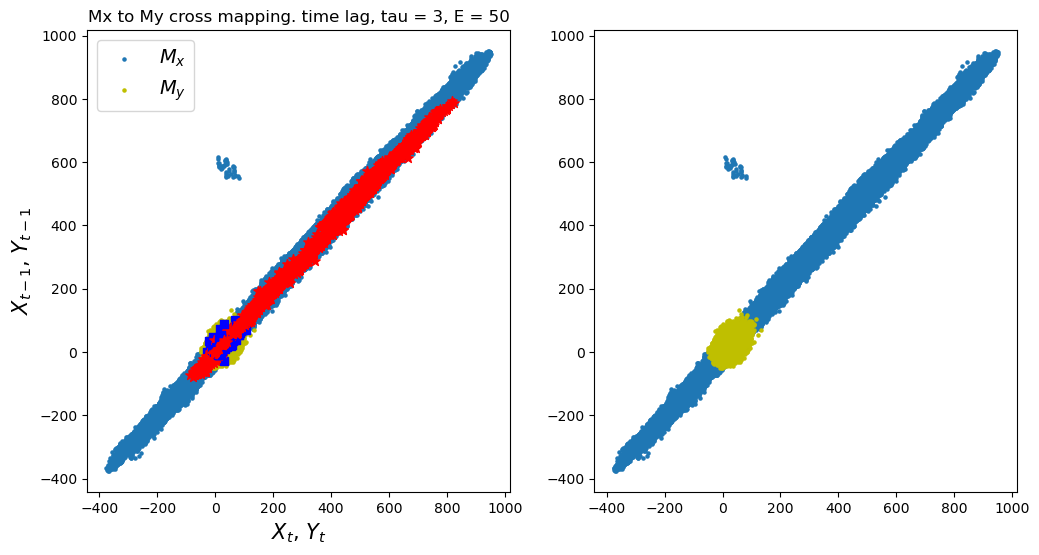

In [33]:
ccm1.visualize_cross_mapping()

shapes (7853,66) and (7853,66) not aligned: 66 (dim 1) != 7853 (dim 0)


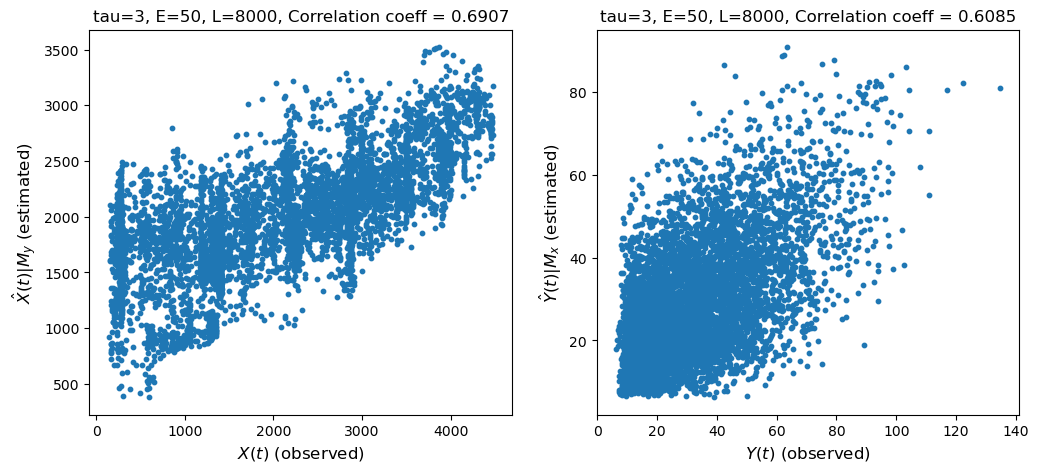

In [34]:
ccm1.plot_ccm_correls()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [47:14<00:00, 166.72s/it]


Text(0.5, 1.0, 'Original Data - Convergence')

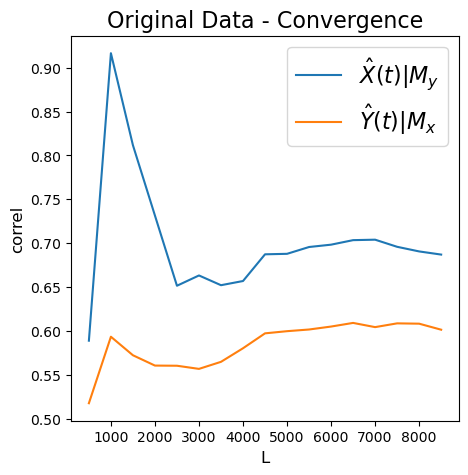

In [35]:
# Looking at "convergence"
L_range = range(500, 8800, 500) # L values to test
tau = 3
E = 50

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 
plt.title(f'Original Data - Convergence', size=16)

### Using Ego Pose with Original data

In [36]:
COM_kps = kps_df.values.reshape((len(kps_df),-1, 3))[:,0,:]
body_kps = kps_df.values.reshape((len(kps_df),-1, 3))[:,1:,:]
ego_kps = body_kps - COM_kps[:, np.newaxis, :]
X = ego_kps.reshape((len(kps_df),-1))
Y = cadfF_df.values

In [37]:
tau = 3 # time lag
E = 50 # shadow manifold embedding dimensions
L = 8000 # length of time period to consider

# ccm1 = ccm(X[:,0], Y[:,0], tau, E, L)
ccm1 = ccm(X, Y, tau, E, L)
# ccm1.visualize_cross_mapping()

In [38]:
# ccm1.visualize_cross_mapping()

shapes (7853,63) and (7853,63) not aligned: 63 (dim 1) != 7853 (dim 0)


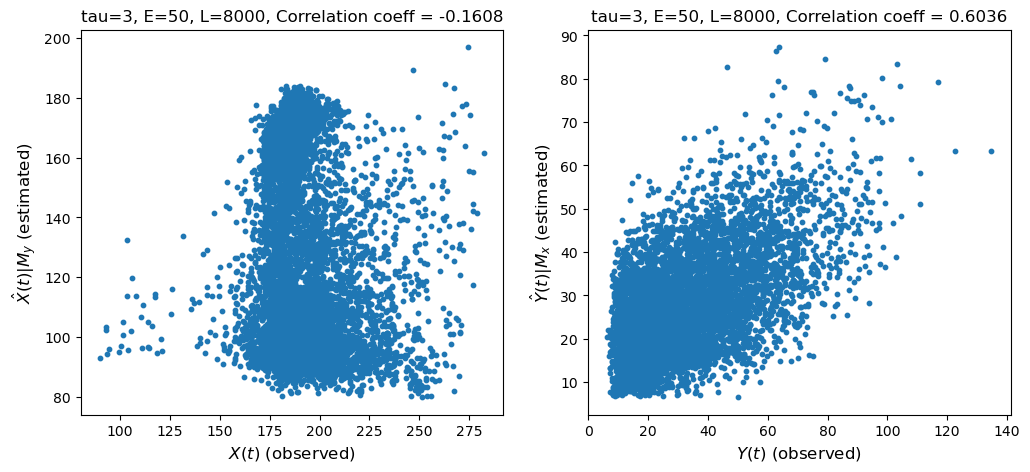

In [39]:
ccm1.plot_ccm_correls()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [46:40<00:00, 164.76s/it]


Text(0.5, 1.0, 'Using Ego Pose with Original Data')

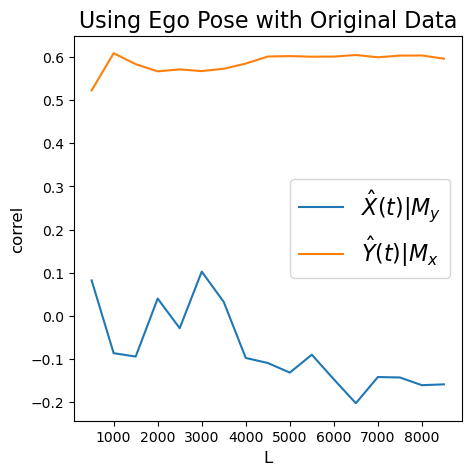

In [40]:
# Looking at "convergence"
L_range = range(500, 8800, 500) # L values to test
tau = 3
E = 50

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 
plt.title(f'Using Ego Pose with Original Data', size=16)

### Using Filtered df_F and normal pose

In [41]:
filt_dfF_df = cadfF_df[cadfF_df.columns[np.where((cadfF_df.std() > 1.5) & (cadfF_df.std() < 20))[0]]]
# np.where(cadfF_df.std() > 20)[0][0]

In [42]:
X = kps_df.values
Y = filt_dfF_df.values

In [43]:
tau = 3 # time lag
E = 50 # shadow manifold embedding dimensions
L = 8000 # length of time period to consider

# ccm1 = ccm(X[:,0], Y[:,0], tau, E, L)
ccm1 = ccm(X, Y, tau, E, L)
# ccm1.visualize_cross_mapping()

In [44]:
# ccm1.visualize_cross_mapping()

shapes (7853,66) and (7853,66) not aligned: 66 (dim 1) != 7853 (dim 0)


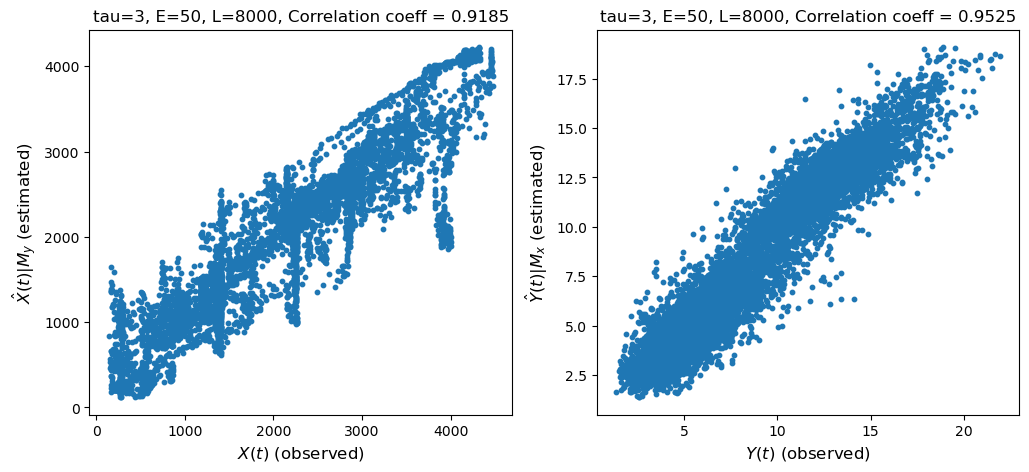

In [45]:
ccm1.plot_ccm_correls()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [25:00<00:00, 88.27s/it]


Text(0.5, 1.0, 'Using Filtered df_F with original pose')

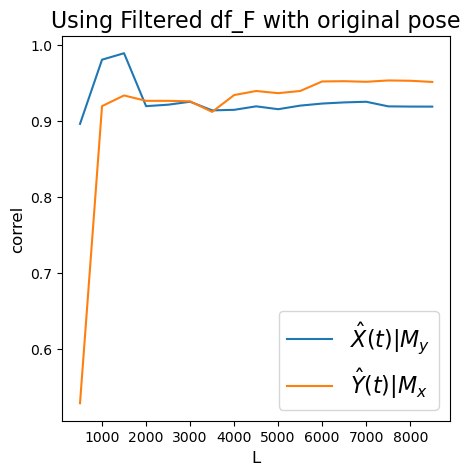

In [46]:
# Looking at "convergence"
L_range = range(500, 8800, 500) # L values to test
tau = 3
E = 50

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 
plt.title(f'Using Filtered df_F with original pose', size=16)

### Using filered df_F and ego pose

In [47]:
X = ego_kps.reshape((len(kps_df),-1))
Y = filt_dfF_df.values

In [48]:
ccm1 = ccm(X, Y, tau, E, L)

In [49]:
# ccm1.visualize_cross_mapping()

shapes (8353,63) and (8353,63) not aligned: 63 (dim 1) != 8353 (dim 0)


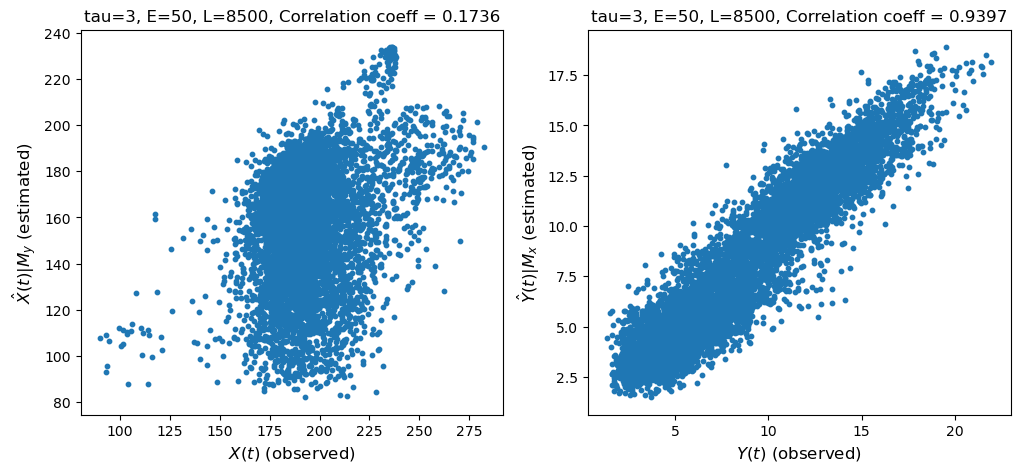

In [50]:
ccm1.plot_ccm_correls()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [24:05<00:00, 85.03s/it]


Text(0.5, 1.0, 'Using Filtered df_F with ego pose')

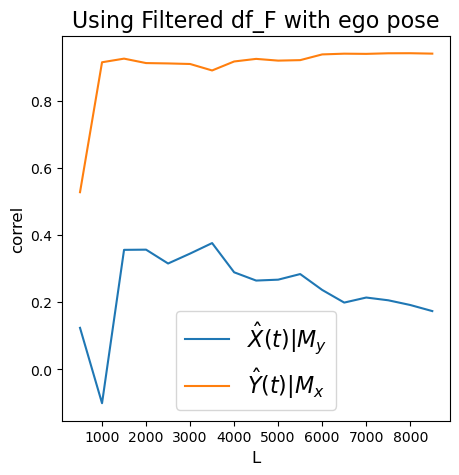

In [51]:
# Looking at "convergence"
L_range = range(500, 8800, 500) # L values to test
tau = 3
E = 50

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 
plt.title(f'Using Filtered df_F with ego pose', size=16)

### Using a 10 frame shift

In [52]:
X = kps_df.values[10:,:]
Y = filt_dfF_df.values[:-10,:]

In [53]:
X.shape, Y.shape

((8884, 66), (8884, 14))

In [54]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 3 # time lag
E = 50 # shadow manifold embedding dimensions
L = 8000 # length of time period to consider

# ccm1 = ccm(X[:,0], Y[:,0], tau, E, L)
ccm1 = ccm(X, Y, tau, E, L)
# ccm1.visualize_cross_mapping()

In [55]:
# ccm1.visualize_cross_mapping()

shapes (7853,66) and (7853,66) not aligned: 66 (dim 1) != 7853 (dim 0)


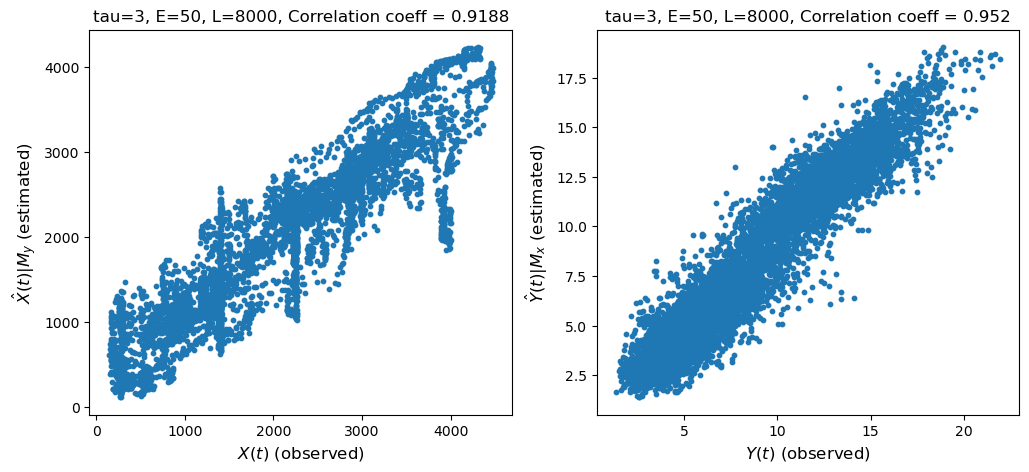

In [56]:
ccm1.plot_ccm_correls()

shapes (7853,66) and (7853,66) not aligned: 66 (dim 1) != 7853 (dim 0)


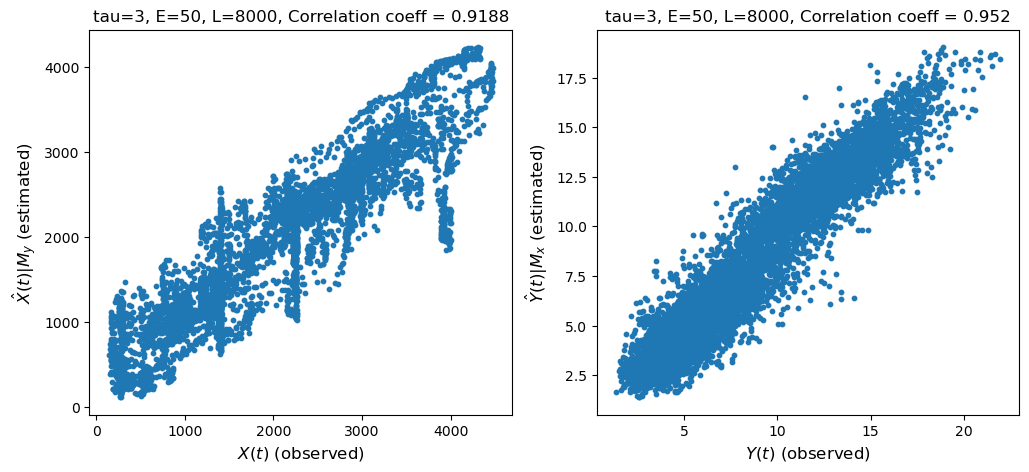

In [57]:
# ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
# ccm_YX = ccm(Y[:,0], X, tau, E, L) # define new ccm object # Testing for Y -> X
ccm1.plot_ccm_correls()

In [58]:
ccm1.dists.shape, ccm1.t_steps.shape

((7853, 7853), (7853,))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [26:23<00:00, 93.15s/it]


Text(0.5, 1.0, 'Filtered df_F, original pose w/ 10 frame lag')

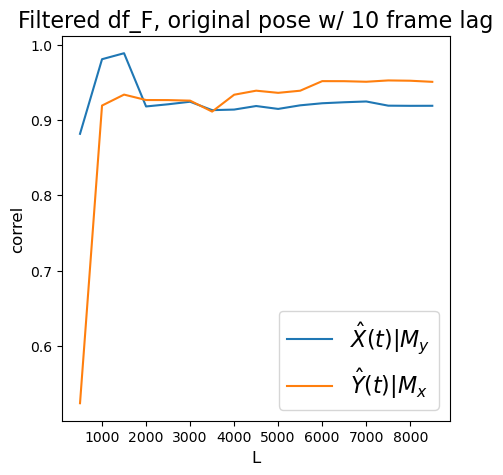

In [59]:
# Looking at "convergence"
L_range = range(500, 8800, 500) # L values to test
tau = 3
E = 50

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 
plt.title(f'Filtered df_F, original pose w/ 10 frame lag', size=16)

### Using a 10 frame shift with ego pose

In [60]:
X = kps_df.values[10:,:]
Y = filt_dfF_df.values[:-10,:]

In [61]:
tau = 3 # time lag
E = 50 # shadow manifold embedding dimensions
L = 8000 # length of time period to consider

# ccm1 = ccm(X[:,0], Y[:,0], tau, E, L)
ccm1 = ccm(X, Y, tau, E, L)

In [62]:
# ccm1.visualize_cross_mapping()

shapes (7853,66) and (7853,66) not aligned: 66 (dim 1) != 7853 (dim 0)


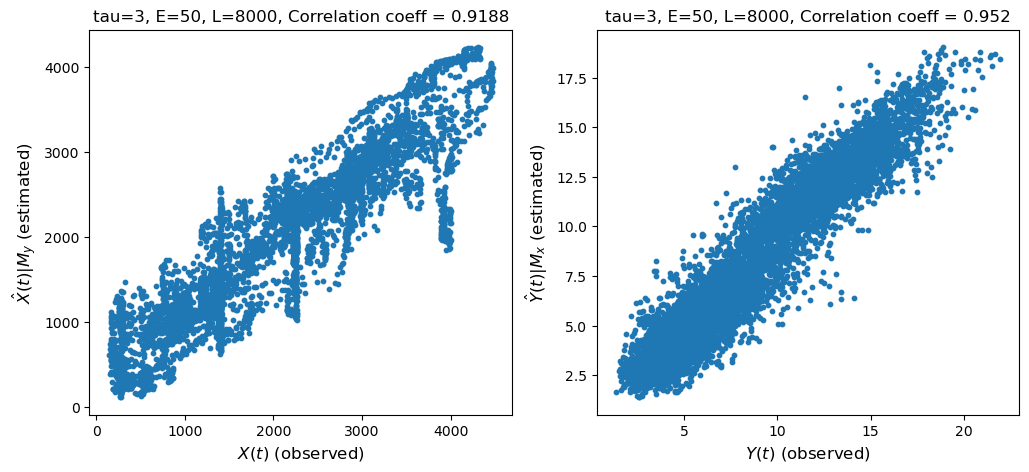

In [63]:
ccm1.plot_ccm_correls()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [1:07:39<00:00, 96.66s/it]


Text(0.5, 1.0, 'Filtered df_F, ego pose w/ 10 frame lag')

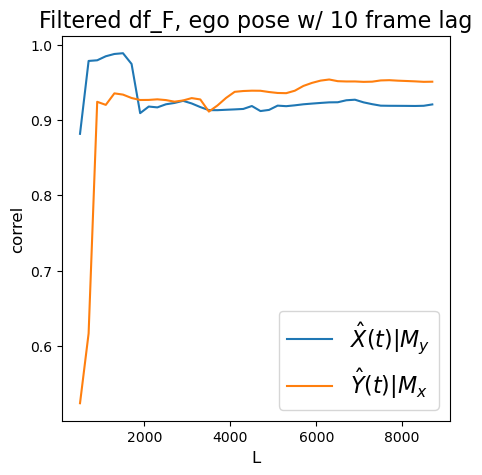

In [64]:
# Looking at "convergence"
L_range = range(500, 8800, 200) # L values to test
tau = 3
E = 50

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 
plt.title(f'Filtered df_F, ego pose w/ 10 frame lag', size=16)

In [65]:
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 4))

X->Y r 0.92 p value 0.0
Y->X r 0.95 p value 0.0
